# Topic Modeling with LDA and Word2Vec Visualization

This notebook demonstrates how to perform **Latent Dirichlet Allocation (LDA)** topic modeling on text documents and visualize the results using **Word2Vec embeddings**. The code is designed to work with both English and Urdu text corpora, making it particularly useful for Digital Humanities researchers working with multilingual datasets.

## What is Topic Modeling?

**Topic modeling** is a statistical technique that automatically discovers abstract "topics" from a collection of documents. Each topic is represented as a probability distribution over words, revealing which words tend to appear together in similar contexts.

**LDA (Latent Dirichlet Allocation)** is one of the most popular topic modeling algorithms. It assumes:
- Each document contains multiple topics in different proportions
- Each topic is characterized by a distribution of words
- Words in documents are generated based on these topic-word distributions

## What You'll Learn

1. **Data Loading**: How to load text from local files or Universal Dependencies treebanks
2. **Text Preprocessing**: Cleaning and preparing text for topic modeling (especially for Urdu)
3. **LDA Training**: Setting up and training topic models with appropriate parameters
4. **Topic Naming**: Using AI to generate human-readable topic names
5. **Visualization**: Creating 2D and 3D visualizations of topics using Word2Vec embeddings

## Prerequisites

Before running this notebook, ensure you have:
- OpenAI API key (for topic naming)
- Required Python packages: `gensim`, `openai`, `LughaatNLP`, `scikit-learn`, `matplotlib`
- Text documents in `.txt` format or access to Universal Dependencies data

## Key Concepts for Digital Humanities

- **Distant Reading**: Topic modeling enables analysis of large text collections without reading every document
- **Corpus Analysis**: Identify recurring themes across historical texts, literary works, or cultural documents  
- **Comparative Studies**: Compare topic distributions across different time periods, authors, or regions
- **Exploratory Analysis**: Discover unexpected patterns and connections in your textual data

In [58]:
from typing import Union, List
from openai import OpenAI

MODEL_NAME = "gpt-4o"  # Default model name



def run_openai_query(query: Union[str, List[str]], use_tools: bool = False):
    client = OpenAI()
    if isinstance(query, str):
        if use_tools:
            response = client.responses.create(
                model=MODEL_NAME,
                tools=[{"type": "web_search_preview"}],
                input=f"{query}",
            )
        else:
            response = client.responses.create(
                model=MODEL_NAME,
                input=f"{query}",
            )
    else:
        chat_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=query,
        )
        response = chat_response.choices[0].message.content
        
    return response


## OpenAI Integration Setup

This section sets up the connection to OpenAI's API for automatic topic naming. The `run_openai_query()` function serves as a wrapper that can handle both simple text queries and chat-based conversations.

### Key Components:

- **MODEL_NAME**: Specifies which OpenAI model to use (GPT-4o by default for better quality)
- **Flexible Input**: Can accept either a single string or a list of messages for chat completion
- **Tool Integration**: Optional web search capabilities for enhanced responses

### For Digital Humanities Researchers:

This integration allows the system to automatically generate meaningful, human-readable names for discovered topics instead of just showing lists of words. This is crucial for interpretability in humanities research where understanding the semantic meaning of topics is essential.

In [59]:
import os
import re
from typing import List, Dict, Union
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from LughaatNLP import LughaatNLP
from tqdm.auto import tqdm
from conllu import parse_incr, TokenList
from datasets import load_dataset


# --- Oracle function (assumed to exist elsewhere) ---
# def get_topic_name(words: List[str]) -> str:
#     """Returns a human-readable name for a topic given its top words."""
#     ...

def preprocess_urdu_doc(doc: str) -> List[str]:
    """Tokenize, lowercase, remove stopwords and short tokens for Urdu."""
    # Assuming a similar preprocessing function exists for Urdu
    urdu_text_processing = LughaatNLP()
    normalized_text = urdu_text_processing.normalize(doc)
    lemmatized_sentence = urdu_text_processing.lemmatize_sentence(normalized_text)
    stemmed_sentence = urdu_text_processing.urdu_stemmer(lemmatized_sentence)
    filtered_text = urdu_text_processing.remove_stopwords(stemmed_sentence)
    tokenized_text = urdu_text_processing.urdu_tokenize(filtered_text)
    
    return tokenized_text


def preprocess(doc: str, language='en') -> List[str]:
    """Tokenize, lowercase, remove stopwords and short tokens."""
    if language == 'ur':
        return preprocess_urdu_doc(doc)
    return [
        token
        for token in simple_preprocess(doc, deacc=True)
        if token not in STOPWORDS and len(token) > 3
    ]




def read_conllu(file_path: str) -> List[TokenList]:
    """
    Reads a CoNLL-U file and returns a list of conllu.TokenList objects,
    one per sentence. Each TokenList behaves like a list of dicts, where
    each dict has keys: 'id', 'form', 'lemma', 'upos', 'xpos', 'feats',
    'head', 'deprel', 'deps', and 'misc'.
    
    Args:
        file_path: path to the .conllu file
        
    Returns:
        List of TokenList, each representing one sentence.
    """
    docs: List[TokenList] = []
    with open(file_path, "r", encoding="utf-8") as f:
        for token_list in parse_incr(f):
            docs.append(token_list)
    return docs


def get_conll_doc_texts(conllu_path: str) -> List[str]:
    """
    Reads a CoNLL-U file and returns the text of each sentence.
    
    - If the CoNLL-U has a metadata line `# text = …`, that exact string is used.
    - Otherwise, tokens are joined by spaces to reconstruct the sentence.
    """
    docs = read_conllu(conllu_path)
    texts = []
    for doc in docs:
        # Check for metadata line first
        if 'text' in doc.metadata:
            texts.append(doc.metadata['text'])
        else:
            # Join tokens by space if no metadata text
            texts.append(" ".join(token['form'] for token in doc))
    return texts


def get_language_conllu_code(language: str) -> str:
    """
    Returns the CoNLL-U language code for a given language.
    
    Args:
    """
    if language == "ur":
        language = "ur_udtb"
    elif language == "en":
        language = "en_ewt"
    elif language == "fr":
        language = "fr_gsd"
    elif language == "de":
        language = "de_gsd"
    elif language == "es":
        language = "es_gsd"
    elif language == "ar":
        language = "ar_padt"
    elif language == "hi":
        language = "hi_hdtb"
    elif language == "zh":
        language = "zh_gsd"
    elif language == "ru":
        language = "ru_syntagrus"
    elif language == "ja":
        language = "ja_gsd"
    elif language == "ko":
        language = "ko_gsd"
    elif language == "it":
        language = "it_isdt"
    elif language == "pt":
        language = "pt_bosque"
    elif language == "tr":
        language = "tr_imst"
    else:
        raise ValueError(f"Unsupported language: {language}. Please provide a valid language code.")
    return language


def load_conll_data(language: str = "en") -> List[str]:
    """Loads CoNLL data for a given language."""
    # Load other languages' CoNLL data
    # Note: You can specify other language codes as needed
    # e.g., "en_ewt" for English, "fr_gsd"
    # or any other language supported by Universal Dependencies
    # For example, "en_ewt" for English EWT treebank
    # or "fr_gsd" for French GSD treebank
    # Adjust the language code as needed
    ud = load_dataset("universal_dependencies", get_language_conllu_code(language))

    splits = {
        "train": ud["train"],
        "validation": ud.get("validation", ud.get("dev")),
        "test": ud["test"],
    }
    
    return sum([d["text"] for d in splits.values()], [])


def read_folder_files(
    folder_path: str,
    file_extension: str = ".txt",
    threshold: float = 0.7
) -> List[str]:
    """Reads all files with a given extension from a folder."""

    # compile once: Unicode ranges covering Urdu/Arabic script
    URDU_RE = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]')

    def is_mostly_urdu(line: str, threshold: float = 0.7) -> bool:
        """
        Check if the majority of non-whitespace characters in `line` are Urdu.
        
        Args:
            line:    input string (one line of text)
            threshold: fraction (0-1) above which we consider it "mostly Urdu"
                    (default 0.5)
        
        Returns:
            True if (Urdu_chars / non_space_chars) > threshold.
        """
        # count non-whitespace chars
        non_space_chars = [c for c in line if not c.isspace()]
        total = len(non_space_chars)
        if total == 0:
            return False
        
        # count Urdu script chars
        urdu_count = sum(bool(URDU_RE.match(c)) for c in non_space_chars)
        
        return (urdu_count / total) > threshold

    
    documents = []
    for filename in os.listdir(folder_path):
        if file_extension in ['.conll', '.conllu'] and filename.endswith(file_extension):
            sentences = get_conll_doc_texts(os.path.join(folder_path, filename))
            documents.extend(sentences)
        
        elif filename.endswith(file_extension):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                doc = f.read().replace("www.emarsiya.com", "")
                doc = "\n\n".join(
                    "\n".join([line for line in paragraph.split("\n") if is_mostly_urdu(line, threshold=threshold)]) 
                    for paragraph in doc.split("\n\n")
                )
                documents.append(doc.strip())
    return documents


def get_documents_data(
    docs_path: str = None, 
    file_extension: str = ".conllu",
    threshold: float = 0.7,
    use_ud: Union[bool, None] = None, 
    language='en'
):
    assert use_ud in [None, True, False], "use_ud must be None, True, or False"
    assert use_ud is not None or isinstance(docs_path, str), "If use_ud is None, docs_path must be a string path to a folder."
    if use_ud:
        # Load CoNLL data for Urdu
        documents = load_conll_data(language=language)
    if isinstance(docs_path, str):
        documents = read_folder_files(docs_path, file_extension=file_extension, threshold=threshold)
    
    print(f"Loaded {len(documents)} documents from {docs_path} with extension {file_extension}.")
    assert len(documents) > 0, "No documents loaded. Check the path and file extension."
    
    texts = [preprocess(doc, language) for doc in tqdm(documents, desc="Preprocessing documents")]
    
    return texts

## Data Loading and Preprocessing Functions

This section contains the core functions for loading, cleaning, and preprocessing text data for topic modeling. The functions support both English and Urdu text, with special handling for different file formats and data sources.

### Key Functions Explained:

#### `preprocess_urdu_doc(doc: str) -> List[str]`
- **Purpose**: Specialized preprocessing for Urdu text using LughaatNLP library
- **Process**: Normalization → Lemmatization → Stemming → Stopword removal → Tokenization
- **Why Important**: Urdu requires different handling due to its script, morphology, and linguistic features

#### `preprocess(doc: str, language='en') -> List[str]`
- **Purpose**: General preprocessing function that routes to appropriate language-specific handlers
- **English Processing**: Uses Gensim's simple_preprocess with stopword filtering
- **Token Filtering**: Removes tokens shorter than 3 characters and common stopwords

#### `read_conllu(file_path: str) -> List[TokenList]`
- **Purpose**: Reads CoNLL-U formatted linguistic annotation files
- **Returns**: Parsed sentences with rich linguistic information (POS, dependencies, etc.)
- **Use Case**: Working with syntactically annotated corpora

#### `get_conll_doc_texts(conllu_path: str) -> List[str]`
- **Purpose**: Extracts plain text from CoNLL-U files for topic modeling
- **Priority**: Uses metadata text field if available, otherwise reconstructs from tokens
- **Why Useful**: Bridges between linguistic annotation and topic modeling workflows

#### `load_conll_data(language: str = "en") -> List[str]`
- **Purpose**: Downloads and loads Universal Dependencies treebank data
- **Supports**: Multiple languages including English, Urdu, Arabic, French, etc.
- **Advantage**: Access to standardized, high-quality linguistic data

#### `read_folder_files(folder_path: str, file_extension: str = ".txt") -> List[str]`
- **Purpose**: Batch loads text files from a directory
- **Special Features**: 
  - Urdu text detection and filtering
  - Support for both plain text and CoNLL-U files
  - Quality filtering based on script detection
- **Threshold Parameter**: Controls how much of the text must be in target script

### For Digital Humanities Applications:

These functions enable researchers to work with diverse text sources:
- **Historical Archives**: Load collections of digitized texts
- **Multilingual Corpora**: Handle texts in different languages and scripts
- **Annotated Data**: Utilize linguistically enriched datasets
- **Quality Control**: Filter out low-quality or irrelevant content

In [60]:
def train_lda_and_name_topics(
    texts: List[str],
    num_topics: int = 10,
    topn: int = 50,
    no_below: int = 5,
    no_above: float = 0.5
) -> Dict[int, str]:
    """
    Given raw documents, trains an LDA model and returns a mapping
    from topic IDs to human-readable topic names.
    """
    # 1. Preprocessing

    # 2. Build dictionary & filter extremes
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)  # adjust thresholds as needed

    # 3. Build corpus
    corpus = [dictionary.doc2bow(text) for text in texts]

    # 4. Train LDA
    lda = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42,
    )

    # 5. Extract top words and name topics
    topic_names: Dict[int, str] = {}
    for topic_id in range(num_topics):
        top_words_and_scores = lda.show_topic(topic_id, topn=topn)
        top_words = [word for word, score in top_words_and_scores]
        name = get_topic_name(top_words)
        topic_names[topic_id] = name

    return {
        'lda': lda,
        'dictionary': dictionary,
        'names': topic_names,
    }


def get_topic_name(words: List[str]) -> str:
    messages = [ 
        {
            "role": "system",
            "content": "You are a topic modeling naming assistant. "
            "Your task is to provide concise, human-readable names for topics based on their top words."
            "Provide the topic always in the same language as the words provided, ",
            
        }, 
        {
        "role": "user",
        "content":
            f"Topic words: {', '.join(words)}"
            "Please provide a human-readable name for this topic."
        }
    ]
    
    topic = run_openai_query(messages, use_tools=False)
    return topic.strip() if topic else "Unnamed Topic"


def run_lda_and_name_topics(
    documents: List[List[str]],
    num_topics: int = 3, 
    topn: int = 50
) -> Dict[int, str]:
    """ Trains an LDA model on a set of documents and names the topics."""
    # Example usage:
    
    lda_output = train_lda_and_name_topics(
        texts=documents, 
        num_topics=num_topics, 
        topn=topn
    )
    
    for tid, tname in lda_output['names'].items():
        print(f"Topic {tid+1}: {tname}")
    
    return lda_output


## LDA Topic Modeling and Automatic Topic Naming

This section implements the core topic modeling functionality using Latent Dirichlet Allocation (LDA) and integrates automatic topic naming using AI.

### Key Functions Explained:

#### `train_lda_and_name_topics(texts, num_topics=10, topn=50, no_below=5, no_above=0.5)`
- **Purpose**: Complete pipeline from preprocessed texts to named topics
- **Parameters**:
  - `texts`: List of preprocessed documents (lists of tokens)
  - `num_topics`: Number of topics to discover (adjust based on corpus size)
  - `topn`: Number of top words to extract per topic for naming
  - `no_below`: Remove words appearing in fewer than N documents
  - `no_above`: Remove words appearing in more than N% of documents
- **Process**:
  1. **Dictionary Creation**: Build vocabulary from corpus
  2. **Filtering**: Remove very rare and very common words
  3. **Corpus Vectorization**: Convert texts to bag-of-words format
  4. **LDA Training**: Learn topic-word distributions
  5. **Topic Naming**: Generate human-readable topic names

#### `get_topic_name(words: List[str]) -> str`
- **Purpose**: Uses OpenAI to generate descriptive names from topic word lists
- **Input**: List of most relevant words for a topic
- **Output**: Human-readable topic name
- **Advantage**: Transforms cryptic word lists into interpretable labels

#### `run_lda_and_name_topics(documents, num_topics=3, topn=50)`
- **Purpose**: Convenience function that runs the complete pipeline and displays results
- **Output**: Prints numbered topics with their AI-generated names
- **Returns**: Complete LDA output including model, dictionary, and topic names

### Parameter Tuning Guidelines:

#### Number of Topics (`num_topics`)
- **Small corpora (< 100 docs)**: 3-10 topics
- **Medium corpora (100-1000 docs)**: 10-50 topics  
- **Large corpora (> 1000 docs)**: 50-200 topics
- **Rule of thumb**: Start small and increase until topics become too specific

#### Vocabulary Filtering
- **`no_below=5`**: Words must appear in at least 5 documents
- **`no_above=0.5`**: Words appearing in > 50% of documents are removed
- **Adjust based on corpus**: Larger corpora can use stricter thresholds

### For Digital Humanities Research:

This approach is particularly valuable for:
- **Thematic Analysis**: Discover recurring themes in literary collections
- **Historical Patterns**: Track topic evolution across time periods
- **Comparative Studies**: Compare topics across different authors, regions, or genres
- **Archive Exploration**: Navigate large document collections efficiently
- **Interpretability**: AI-generated topic names make results accessible to non-technical researchers

In [61]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull


def plot_w2v_topics_3d(lda_output, docs, num_topics=5, topn=10):
    """
    Plots LDA topics in 3D using Word2Vec embeddings.
    
    Args:
        lda_output: output from run_lda_and_name_topics
        docs: list of preprocessed documents
        num_topics: number of topics to visualize
    """
    # 1) Get top words for each topic

    topn = 10
    topic_words = dict()
    for t in range(num_topics):
        topic_words[t] = [word for word, _ in lda_output['lda'].show_topic(t, topn)]

    w2v = Word2Vec(sentences=docs, vector_size=100, window=5,
                min_count=5, workers=4, seed=42)

    # 6) Gather embeddings for all topic words
    all_words = [w for words in topic_words.values() for w in words]
    unique_words = [w for w in dict.fromkeys(all_words) if w in w2v.wv]
    embs = np.stack([w2v.wv[w] for w in unique_words])

    # 7) Project to 3D
    pca = PCA(n_components=3, random_state=42)
    coords3d = pca.fit_transform(embs)
    word2coord = {w: coords3d[i] for i, w in enumerate(unique_words)}

    # 8) Plot in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.tab10(np.linspace(0, 1, num_topics))

    for t in range(num_topics):
        words = [w for w in topic_words[t] if w in word2coord]
        pts = np.array([word2coord[w] for w in words])

        # scatter points
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                color=colors[t], s=50, label=f"Topic {t}")

        # annotate each point with its word
        for w, (x, y, z) in zip(words, pts):
            ax.text(x, y, z, w, fontsize=9, color=colors[t])

        # optional: draw convex hull around the cluster
        if len(pts) >= 4:
            hull = ConvexHull(pts)
            for simplex in hull.simplices:
                seg = pts[simplex]
                ax.plot(seg[:, 0], seg[:, 1], seg[:, 2],
                        color=colors[t], alpha=0.4)

    ax.set_title("LDA Topics + Word2Vec in 3D (PCA Projection)")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


def plot_w2v_topics_2d(lda_output, docs, num_topics=5, topn=10):
    """
    Plots LDA topics in 2D using Word2Vec embeddings.
    
    Args:
        lda_output: output from run_lda_and_name_topics
        texts: list of preprocessed documents
        num_topics: number of topics to visualize
    """
    # 5. Extract top-n words per topic
    topic_words = []
    for t in range(num_topics):
        topic_words.append([word for word, _ in lda_output['lda'].show_topic(t, topn)])

    # 6. Train Word2Vec on the same corpus
    w2v_model = Word2Vec(sentences=docs, vector_size=100, window=5,
                        min_count=5, workers=4, seed=42)

    # 7. Collect vectors for all topic words
    all_words = set(sum(topic_words, []))
    word_vecs = {w: w2v_model.wv[w] for w in all_words if w in w2v_model.wv}

    # 8. Dimensionality reduction (PCA to 2D)
    pca = PCA(n_components=2, random_state=42)
    X = pca.fit_transform(list(word_vecs.values()))
    words = list(word_vecs.keys())

    # 9. Plot
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10.colors  # up to 10 distinct colors

    for topic_idx, words_in_topic in enumerate(topic_words):
        xs, ys = [], []
        for w in words_in_topic:
            if w in word_vecs:
                idx = words.index(w)
                xs.append(X[idx, 0])
                ys.append(X[idx, 1])
                plt.text(X[idx, 0], X[idx, 1], w, fontsize=12,
                        color=colors[topic_idx % len(colors)])
        # draw convex hull / polygon around the cluster (optional)
        if len(xs) >= 3:
            from scipy.spatial import ConvexHull
            points = list(zip(xs, ys))
            hull = ConvexHull(points)
            hull_pts = [points[v] for v in hull.vertices] + [points[hull.vertices[0]]]
            hx, hy = zip(*hull_pts)
            plt.plot(hx, hy, color=colors[topic_idx % len(colors)], alpha=0.5)

    plt.title("LDA + Word2Vec Topic Visualization")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()


## Topic Visualization with Word2Vec Embeddings  

This section provides sophisticated visualization functions that combine LDA topic modeling with Word2Vec embeddings to create intuitive 2D and 3D visualizations of discovered topics.

### Why Combine LDA with Word2Vec?

- **LDA** discovers topics as probability distributions over words
- **Word2Vec** captures semantic similarity between words in vector space  
- **Combination** allows us to visualize topics as clusters of semantically related words in geometric space

### Key Functions Explained:

#### `plot_w2v_topics_3d(lda_output, docs, num_topics=5, topn=10)`
- **Purpose**: Creates 3D scatter plot of topics in Word2Vec embedding space
- **Process**:
  1. **Topic Word Extraction**: Gets top N words for each topic from LDA
  2. **Word2Vec Training**: Trains embeddings on the same corpus used for LDA
  3. **Dimensionality Reduction**: Uses PCA to project high-dimensional embeddings to 3D
  4. **Visualization**: Colors topic words differently and draws convex hulls around clusters
- **Output**: Interactive 3D plot showing topic separation and word relationships

#### `plot_w2v_topics_2d(lda_output, docs, num_topics=5, topn=10)`  
- **Purpose**: Creates 2D visualization of topics using Word2Vec embeddings
- **Advantage**: Easier to interpret than 3D, better for publication
- **Features**:
  - Words are colored by topic membership
  - Convex hulls outline topic boundaries  
  - Clear separation shows topic distinctiveness

### Technical Details:

#### Word2Vec Parameters
- **vector_size=100**: Dimensionality of word embeddings
- **window=5**: Context window size for training
- **min_count=5**: Minimum word frequency threshold
- **workers=4**: Number of parallel threads
- **seed=42**: For reproducible results

#### PCA Projection
- **Purpose**: Reduces 100-dimensional Word2Vec vectors to 2D/3D for visualization
- **Preserves**: Relative distances between words as much as possible
- **Trade-off**: Some information is lost in dimensionality reduction

### Interpreting the Visualizations:

#### Well-Separated Topics
- **Good**: Topics appear as distinct clusters with minimal overlap
- **Indicates**: LDA successfully discovered coherent, distinguishable themes

#### Overlapping Topics  
- **Meaning**: Topics share semantic space, may be related themes
- **Action**: Consider merging similar topics or increasing topic count

#### Outlier Words
- **Scattered words**: May be noise or belong to multiple topics
- **Consider**: Adjusting preprocessing or LDA parameters

### For Digital Humanities Applications:

These visualizations are particularly valuable for:
- **Qualitative Analysis**: Visually assess topic quality and coherence
- **Presentation**: Create compelling graphics for papers and presentations  
- **Exploration**: Discover unexpected relationships between topics
- **Validation**: Verify that discovered topics align with domain knowledge
- **Refinement**: Guide parameter tuning for better topic models

### Usage Tips:

1. **Start with 2D plots** for initial exploration
2. **Use 3D plots** for detailed analysis and impressive presentations
3. **Adjust `topn` parameter** to include more/fewer words per topic
4. **Consider corpus size** when setting Word2Vec parameters
5. **Save high-resolution plots** for publication quality figures

Loaded 241 documents from ../datasets/marsiya-all with extension .txt.


Preprocessing documents:   0%|          | 0/241 [00:00<?, ?it/s]

Topic 1: موضوع برائے رسالت و مقام بلند
Topic 2: ایمانی سوالات و مباحثات
Topic 3: زندگی اور حقیقتیں
Topic 4: Topic Name: **شہادت و وفا کے موضوعات**
Topic 5: موضوع فراق و اسارت


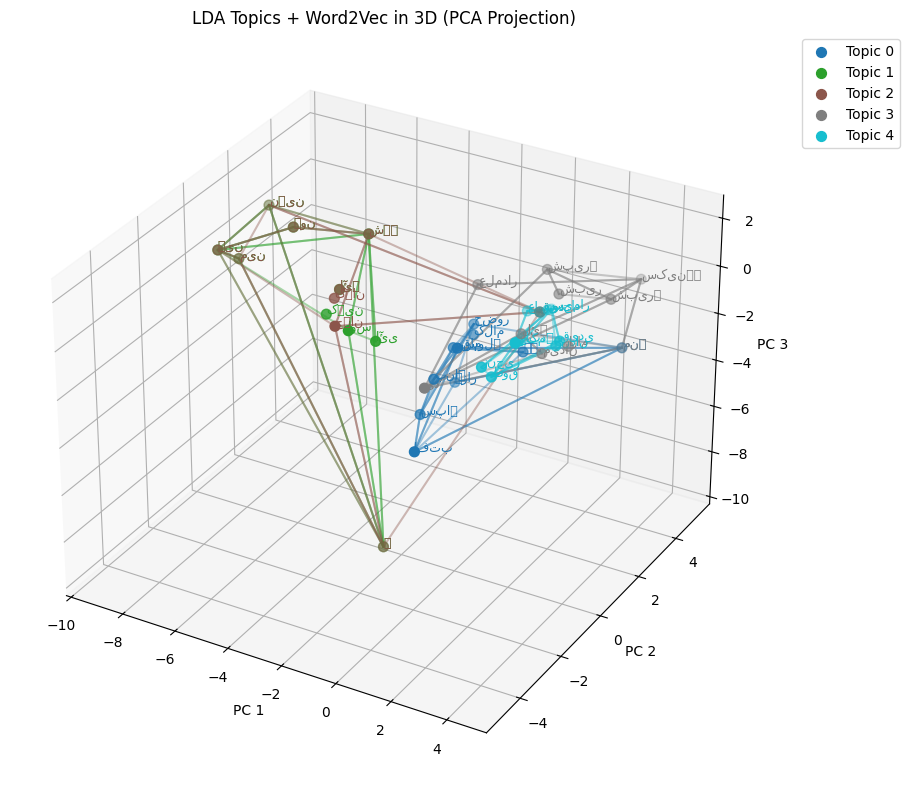

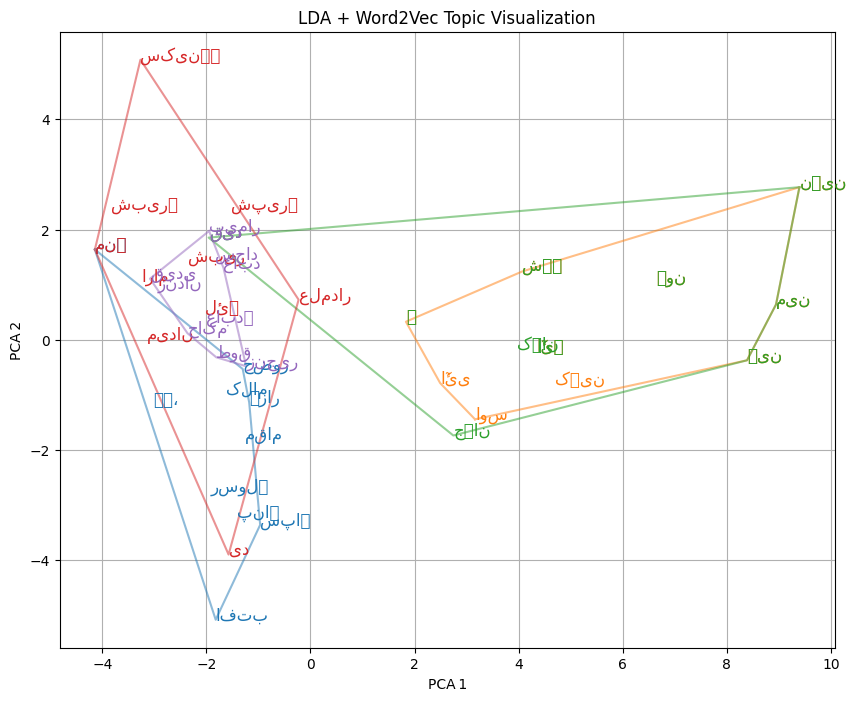

In [63]:
num_topics = 5
topn = 10
language = "ur"  # Change to "ur" for Urdu. Default is "en" for English.
use_ud = False  # Set to True to use Universal Dependencies data directly from internet. False if you have local .conllu files.
docs_path = "../datasets/marsiya-all"  # Change to path/to/your/urdu/documents with .txt or .conllu files
file_extension = ".txt"  # Change to ".conllu" if you have CoNLL-U files



docs = get_documents_data(
    docs_path=docs_path,
    file_extension=file_extension,
    use_ud=use_ud, 
    language=language
)

lda_output = run_lda_and_name_topics(
    documents=docs,
    num_topics=num_topics, 
    topn=topn
)

plot_w2v_topics_3d(lda_output, docs, num_topics=num_topics, topn=topn)
plot_w2v_topics_2d(lda_output, docs, num_topics=num_topics, topn=topn)

## Running the Complete Analysis

This section demonstrates how to execute the complete topic modeling pipeline with customizable parameters. The example is configured for Urdu text analysis but can be easily adapted for other languages.

### Configuration Parameters:

#### Core Settings
- **`num_topics = 5`**: Number of topics to discover
  - *Guidance*: Start with 3-10 for small corpora, scale up for larger datasets
  - *Digital Humanities tip*: Consider your research questions - how many themes do you expect?

- **`topn = 10`**: Number of top words per topic to display and use for naming
  - *Higher values*: More comprehensive topic descriptions
  - *Lower values*: More focused, essential topic words

#### Language and Data Source
- **`language = "ur"`**: Target language (Urdu in this example)
  - *Supported*: "en" (English), "ur" (Urdu), "ar" (Arabic), and others
  - *Impact*: Determines preprocessing pipeline and linguistic tools used

- **`use_ud = False`**: Whether to use Universal Dependencies data from internet
  - *True*: Download standardized linguistic data automatically
  - *False*: Use local files from specified directory

#### Data Location  
- **`docs_path = "../datasets/marsiya-all"`**: Path to your text collection
  - *Adjust*: Point to your own corpus directory
  - *Organization tip*: Keep related documents in the same folder

- **`file_extension = ".txt"`**: Type of files to process
  - *Options*: ".txt", ".conllu", or other text formats
  - *Mixed formats*: The system can handle multiple types in the same directory

### Execution Flow:

1. **Data Loading**: `get_documents_data()` loads and preprocesses all texts
2. **Topic Modeling**: `run_lda_and_name_topics()` discovers topics and generates names  
3. **Visualization**: Both 3D and 2D plots are created automatically

### Expected Output:

The analysis will produce:
- **Topic List**: Numbered topics with AI-generated descriptive names
- **3D Visualization**: Interactive plot showing topic clusters in Word2Vec space  
- **2D Visualization**: Publication-ready plot with clear topic boundaries

### Customization for Your Research:

#### For Literary Analysis:
```python
num_topics = 15  # More granular themes
docs_path = "../texts/shakespeare-plays"
language = "en"
```

#### For Historical Documents:
```python  
num_topics = 8   # Broader historical themes
topn = 15        # More words for complex topics
docs_path = "../archives/colonial-records"
```

#### For Comparative Studies:
```python
# Run separately for different time periods/authors
# then compare resulting topic distributions
```

### Troubleshooting:

- **Empty topic names**: Check OpenAI API key and connectivity
- **Poor topic quality**: Adjust `num_topics`, preprocessing parameters, or corpus size
- **Visualization errors**: Ensure sufficient vocabulary overlap between LDA and Word2Vec
- **Memory issues**: Reduce corpus size or embedding dimensions for large datasets